### Objectives:
- Check the learning curve of the nicheVI model, especially the convergence of validation_loss. REMOVE WARMUP
- Do we need to train the model for more epochs? YES AT LEAST 100
- Do we need to use a smaller learning rate?
- Should we increase the number of layers in the neural network? NO
- Are the observed batch effects specific to the MERFISH dataset or the model? Check with LIVER dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from typing import List, Tuple, Dict, Any, Callable, Optional, Union

In [2]:
import anndata as ad
import numpy as np
import pandas as pd

from rich import print
import os

import scvi

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from scib_metrics.benchmark import Benchmarker
from phenospace.results_analysis import spatial_latent_analysis, SpatialAnalysis

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/

In [5]:
# adata_test = sc.read(
#     "data/lung_atlas.h5ad",
#     backup_url="https://figshare.com/ndownloader/files/24539942",
# )

In [5]:
!pwd

/home/nathanlevy/spatial-scvi/scvi


In [6]:
adata_test = sc.read(
    "/home/nathanlevy/Data/Liver_VIZGEN/liver-joint-scvi3.h5ad",
)

In [7]:
adata_test.X = adata_test.layers["counts"]  # putting in the X matrtix the raw counts

In [8]:
print(adata_test)

AnnData object with n_obs × n_vars = 1275831 × 347
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'sample', 'biopsy', 
'_scvi_batch', '_scvi_labels', 'leiden_scVI', '_scvi_raw_norm_scaling', 'cell_total', 'log1p_cell_total', 
'leiden_scVI_finer', 'leiden_scVI_finer_still', 'leiden_scVI_only_vascular_endothelial', 'endothelial_only', 
'cell_types'
    var: 'n_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'biopsy_colors', 'cell_types_colors', 'dendrogram_leiden_scVI', 
'endothelial_only_colors', 'leiden', 'leiden_scVI_colors', 'leiden_scVI_finer_colors', 
'leiden_scVI_finer_still_colors', 'leiden_scVI_only_vascular_endothelial_colors', 'log1p', 'neighbors', 'pca', 
'sample_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [9]:
adata_test.obs["sample"].value_counts()

sample
Liver1Slice1    395215
Liver2Slice1    318663
Liver2Slice2    307502
Liver1Slice2    254451
Name: count, dtype: int64

In [10]:
# subset the data to only include the samples we want to analyze: Liver1Slice1 and Liver2Slice1
adata_test = adata_test[
    adata_test.obs["sample"].isin(["Liver1Slice1", "Liver2Slice1"])
].copy()

In [11]:
print(adata_test)

AnnData object with n_obs × n_vars = 713878 × 347
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'sample', 'biopsy', 
'_scvi_batch', '_scvi_labels', 'leiden_scVI', '_scvi_raw_norm_scaling', 'cell_total', 'log1p_cell_total', 
'leiden_scVI_finer', 'leiden_scVI_finer_still', 'leiden_scVI_only_vascular_endothelial', 'endothelial_only', 
'cell_types'
    var: 'n_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'biopsy_colors', 'cell_types_colors', 'dendrogram_leiden_scVI', 
'endothelial_only_colors', 'leiden', 'leiden_scVI_colors', 'leiden_scVI_finer_still_colors', 
'leiden_scVI_only_vascular_endothelial_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [12]:
def scvi_pipeline(
    seed: int,
    batch_key: str,
    n_epochs: int,
    n_latent: int = 20,
    n_layers: int = 2,
    save_path: Optional[str] = None,
):
    scvi.settings.seed = seed

    scvi.model.SCVI.setup_anndata(
        adata_test,
        layer="counts",
        batch_key=batch_key,
    )

    scvivae = scvi.model.SCVI(
        adata_test,
        gene_likelihood="nb",
        n_layers=n_layers,
        n_latent=n_latent,
    )

    scvivae.train(
        max_epochs=n_epochs,
        train_size=0.8,
        validation_size=0.2,
        plan_kwargs=dict(n_epochs_kl_warmup=400, weight_decay=1e-2),
        early_stopping=True,
    )

    scvivae.history["reconstruction_loss_train"].plot()
    scvivae.history["elbo_validation"].plot()
    scvivae.history["validation_loss"].plot()

    adata_test.obsm["X_scVI_seed_" + str(seed)] = scvivae.get_latent_representation()

    if save_path is not None:
        scvivae.save(save_path)

In [13]:
seed_list = [50]

In [14]:
for seed in seed_list:
    scvi_pipeline(seed, batch_key="sample", n_epochs=150)

Global seed set to 50


/home/nathanlevy/spatial-scvi/scvi/model/_scvi.py:127: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 93/150:  61%|██████▏   | 92/150 [1:05:43<40:48, 42.22s/it, v_num=1, train_loss_step=271, train_loss_epoch=288]

In [31]:
adata_test.write_h5ad("data/nicheVI_convergence.h5ad")

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


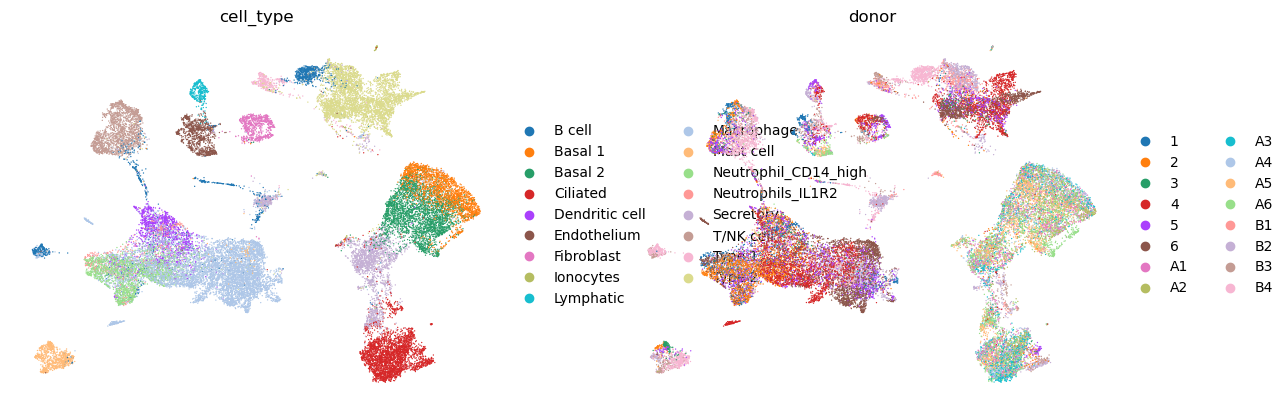

In [ ]:
sc.pp.neighbors(adata_test, use_rep="X_scVI_seed_50")
sc.tl.umap(adata_test, min_dist=0.3)

sc.pl.umap(
    adata_test,
    color=["cell_type", "donor"],
    ncols=2,
    frameon=False,
)

In [32]:
adata_test

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', '_scvi_batch', '_scvi_labels', 'latent_overlap'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'pca', 'neighbors', 'umap', 'cell_type_colors', 'donor_colors'
    obsm: 'X_scVI_seed_50', 'X_scVI_seed_56', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [33]:
embedding_obsm_keys = ["X_scVI_seed_" + str(seed) for seed in seed_list]

bm = Benchmarker(
    adata_test,
    batch_key="donor",
    label_key="cell_type",
    embedding_obsm_keys=embedding_obsm_keys,
    n_jobs=6,
)
bm.benchmark()

Embeddings: 100%|██████████| 2/2 [00:34<00:00, 17.14s/it]


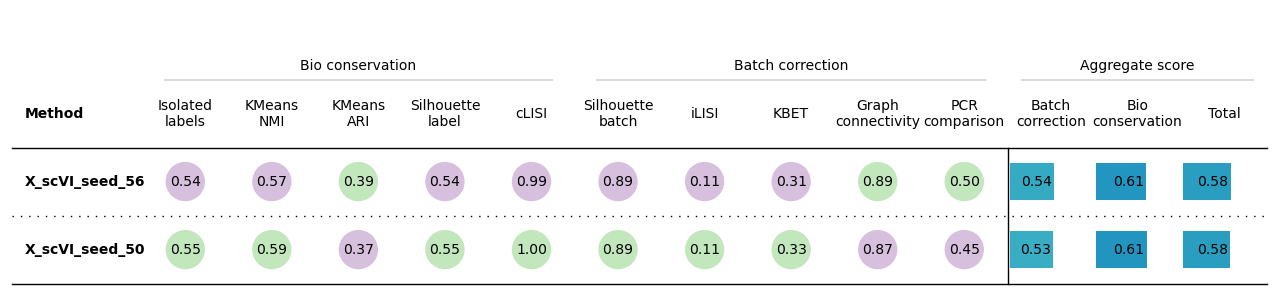

In [34]:
bm.plot_results_table(min_max_scale=False)

In [35]:
sa = SpatialAnalysis(
    adata=adata_test,
    label_key="cell_type",
    sample_key="donor",
    latent_space_keys=[
        "X_scVI_seed_50",
        "X_scVI_seed_56",
    ],
    spatial_coord_key="centroids",
    ct_composition_key="neighborhood_composition",
)


sa.compute_metrics(
    k_nn=50,  # what is the optimal k_nn?
    set_of_metrics=["latent_overlap"],
    similarity_metric="spearman",
    reduction=["median", "mean"],
    z1_reference="X_scVI_seed_50",
    z2_comparison="X_scVI_seed_56",
)

X_scVI_seed_50

100%|██████████| 16/16 [00:00<00:00, 25.83it/s]


X_scVI_seed_56

 25%|██▌       | 4/16 [00:00<00:00, 33.42it/s]

100%|██████████| 16/16 [00:00<00:00, 27.75it/s]


The latent spaces overlap is saved in the.obs column: latent_overlap.

In [36]:
sa.get_latent_overlap()

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Cell type            ┃ Average Jaccard ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Type 2               │ 0.38            │
│ Secretory            │ 0.4             │
│ Type 1               │ 0.22            │
│ Macrophage           │ 0.41            │
│ B cell               │ 0.32            │
│ Endothelium          │ 0.48            │
│ T/NK cell            │ 0.43            │
│ Ciliated             │ 0.41            │
│ Mast cell            │ 0.5             │
│ Fibroblast           │ 0.4             │
│ Lymphatic            │ 0.28            │
│ Ionocytes            │ 0.45            │
│ Basal 2              │ 0.43            │
│ Basal 1              │ 0.44            │
│ Dendritic cell       │ 0.33            │
│ Neutrophil_CD14_high │ 0.36            │
│ Neutrophils_IL1R2    │ 0.44            │
└──────────────────────┴─────────────────┘

In [26]:
sa.get_latent_overlap()

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Cell type            ┃ Average Jaccard ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Type 2               │ 0.41            │
│ Secretory            │ 0.39            │
│ Type 1               │ 0.26            │
│ Macrophage           │ 0.42            │
│ B cell               │ 0.37            │
│ Endothelium          │ 0.49            │
│ T/NK cell            │ 0.45            │
│ Ciliated             │ 0.39            │
│ Mast cell            │ 0.54            │
│ Fibroblast           │ 0.4             │
│ Lymphatic            │ 0.32            │
│ Ionocytes            │ 0.39            │
│ Basal 2              │ 0.41            │
│ Basal 1              │ 0.4             │
│ Dendritic cell       │ 0.34            │
│ Neutrophil_CD14_high │ 0.36            │
│ Neutrophils_IL1R2    │ 0.44            │
└──────────────────────┴─────────────────┘